In [60]:
import torchvision
import math
import torch
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os, sys
from pathlib import Path 
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Pad(2,padding_mode='constant'),
    transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=True,
                                      download=True,
                                      transform=transform)
trainloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

testset = torchvision.datasets.MNIST(root = '/home/luke-padmore/Source/flow-matching-mnist/data',
                                      train=False,
                                      download=True,
                                      transform=transform)
testloader = DataLoader(trainset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

## Plotting a grid of images

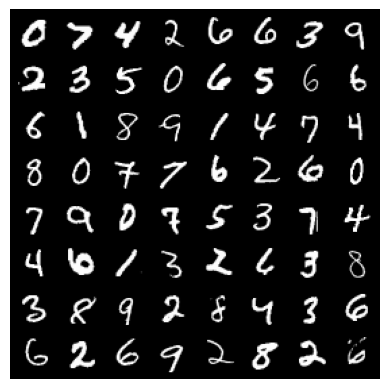

In [53]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8)

plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

In [54]:
%load_ext autoreload
%autoreload 2

In [63]:
import importlib, models.unet as unet
importlib.reload(unet)
from models.unet import ConvDownblock, SinusoidalTimeEmbedding, Encoder, Bottleneck, Decoder
test_down_block = ConvDownblock(
    in_channels = 32,
    out_channels = 32,
    d_trunk = 8,
    d_concat = 8,
    group_norm_size = 8
)

test_encoder = Encoder(
    channels = [1,32,64,128],
    d_trunk = 8,
    d_concat = 8,
    group_norm_size = 8
)

test_bottleneck = Bottleneck(
    channels = 128,
    d_trunk = 8,
    d_concat = 8
)

test_decoder = Decoder(
    channels = [1,32,64,128],
    d_trunk = 8,
    d_concat = 8,
    group_norm_size = 8
)


time_emb_block = SinusoidalTimeEmbedding(trunk_dim = 8)
t = torch.rand(batch_size)

from models.unet import UNet

model = UNet([1,32,64,128],8,8,8,128)

## Testing training objective

In [64]:
torch.manual_seed(0)
x0 = torch.randn_like(images)
x0.shape
v_est = model(1-t[:,None,None,None] * images + t[:,None,None,None] * x0,t)
v_true = images - x0

print(v_true.shape,v_est.shape)
loss = nn.MSELoss()
loss(v_est,v_true)


torch.Size([64, 1, 32, 32]) torch.Size([64, 1, 32, 32])


tensor(1.6750, grad_fn=<MseLossBackward0>)

In [69]:
# Testing overfitting to a single batch
device = torch.device("cuda")
model = UNet([1,32,64,128],8,8,8,128).to(device=device)
optimiser = torch.optim.Adam(params=model.parameters(),lr=1e-3)
mse = nn.MSELoss()
model.train()
def train() -> None: 
    data = images.to(device)
    for _ in range(1000):
        optimiser.zero_grad()
        x0 = torch.randn_like(data).to(device)
        t = torch.rand(batch_size)[:,None,None,None].to(device)
        v_est = model((1-t) * data + t * x0,t)
        v_true = data - x0
        mse = loss(v_est,v_true)
        mse.backward() 
        optimiser.step()
        print(f'Loss = {mse.item():.4f}')



train()

Loss = 2.0454
Loss = 1.4372
Loss = 1.2887
Loss = 1.2039
Loss = 1.1334
Loss = 1.0835
Loss = 0.9522
Loss = 0.8680
Loss = 0.8097
Loss = 0.7745
Loss = 0.7282
Loss = 0.6509
Loss = 0.7350
Loss = 0.6311
Loss = 0.5900
Loss = 0.5725
Loss = 0.5931
Loss = 0.5648
Loss = 0.5608
Loss = 0.4892
Loss = 0.4961
Loss = 0.4544
Loss = 0.4623
Loss = 0.5014
Loss = 0.4263
Loss = 0.4665
Loss = 0.4276
Loss = 0.4620
Loss = 0.4217
Loss = 0.4557
Loss = 0.4183
Loss = 0.4164
Loss = 0.3707
Loss = 0.4139
Loss = 0.4137
Loss = 0.4087
Loss = 0.3998
Loss = 0.3946
Loss = 0.4028
Loss = 0.3822
Loss = 0.4272
Loss = 0.3609
Loss = 0.4143
Loss = 0.3797
Loss = 0.3660
Loss = 0.3708
Loss = 0.3600
Loss = 0.3706
Loss = 0.3598
Loss = 0.3781
Loss = 0.3520
Loss = 0.3544
Loss = 0.3425
Loss = 0.3528
Loss = 0.3541
Loss = 0.3663
Loss = 0.3757
Loss = 0.3341
Loss = 0.3642
Loss = 0.3281
Loss = 0.3101
Loss = 0.3128
Loss = 0.3163
Loss = 0.3314
Loss = 0.3646
Loss = 0.3397
Loss = 0.3392
Loss = 0.3205
Loss = 0.3091
Loss = 0.3171
Loss = 0.2926
Loss =

In [70]:
import importlib, models.ode_solvers as ode_solvers
from models.ode_solvers import euler_solver, rk2_solver
importlib.reload(ode_solvers)

<module 'models.ode_solvers' from '/home/luke-padmore/Source/flow-matching-mnist/models/ode_solvers.py'>

In [84]:
def vf_learned(model):
    def f(x,t):
        t_tensor = torch.full((x.shape[0], 1, 1, 1), fill_value=t, device=x.device)
        return model(x, t_tensor)
    return f

torch.manual_seed(0)
x0 = torch.randn_like(images).to(device)
# ts,xs = euler_solver(vf_learned(model),x0,0.0,1.0,1000)
ts,xs = rk2_solver(vf_learned(model),x0,0.0,1.0,50)

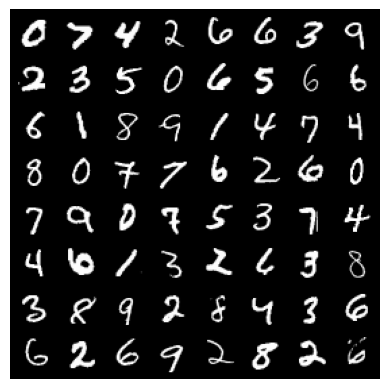

In [85]:
grid = torchvision.utils.make_grid((images + 1) / 2,nrow = 8)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2650357..1.367075].


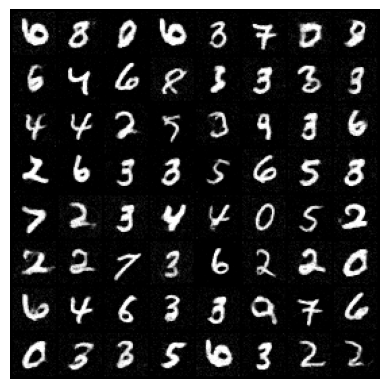

In [86]:
grid = torchvision.utils.make_grid((xs[-1].cpu() + 1)/2,nrow = 8)
plt.imshow(grid.permute(1, 2, 0))  
plt.axis('off')
plt.show()